# Referansemodell i Python

In [209]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from datetime import timedelta

pd.options.mode.chained_assignment = None

In [210]:
df = pd.read_csv("data/tilsyn.csv", sep=';')

In [211]:
# datavask
keep_vars = ['tilsynsobjektid', 'orgnummer', 'navn', 'adrlinje1', 'adrlinje2',
       'postnr', 'poststed', 'tilsynid', 'dato',
       'total_karakter', 'tilsynsbesoektype']
df = df[keep_vars]

In [212]:
df

,tilsynsobjektid,orgnummer,navn,adrlinje1,adrlinje2,postnr,poststed,tilsynid,dato,total_karakter,tilsynsbesoektype
0,Z1006052059576191189LLAJS_Tilsynsobjekt,876576422.0,Malik's Kvarten Bistro AS,KRISTIAN IV`S GATE 1,NaN,164.0,OSLO,Z1601151233010030239YFSGZ_TilsynAvtale,15012016,0,1
1,Z1501071230082032024GTOXC_Tilsynsobjekt,914541034.0,Bakeriet i Brumunddal avdeling CC- Hamar,VANGSVEGEN 62,NaN,2317.0,HAMAR,Z1601211510285150239IKXEO_TilsynAvtale,21012016,1,0
2,Z1006120609250331126HFNXO_Tilsynsobjekt,987770740.0,Aktiven skiheis - Varmestova og Lavo,Kvamskogen,NaN,5600.0,NORHEIMSUND,Z1603101430592020239SQLTI_TilsynAvtale,10032016,1,0
3,Z1107281100559960160KWPRX_Tilsynsobjekt,998066662.0,Golfkafeen,Belsjøveien 50,NaN,1445.0,DRØBAK,Z1605111530190600240CQCNS_TilsynAvtale,11052016,1,0
4,Z1305061320139293177THOPJ_Tilsynsobjekt,911860805.0,Marianne Bakeri og Kafe,ODDEN 2,NaN,5745.0,AURLAND,Z1601281551398970239WJGDG_TilsynAvtale,28012016,3,0
...,...,...,...,...,...,...,...,...,...,...,...
38502,Z2001160832140813158YCIVW_Tilsynsobjekt,923609474.0,Kirkens Bymisjon Notodden,Torvet 4,NaN,3674.0,NOTODDEN,Z2109211526483570239DXQKX_TilsynAvtale,21092021,1,0
38503,Z1609071259126400378YKTNK_Tilsynsobjekt,917507953.0,Kaffelade,Torgalmenningen 8 - Galleriet,NaN,5014.0,BERGEN,Z1706011234148320239ISPHV_TilsynAvtale,31052017,2,0
38504,Z1006120516127581189INJLE_Tilsynsobjekt,990953791.0,Pikekyss,RASMUS RØNNEBERGSGATE,NaN,6003.0,ÅLESUND,Z1604191143049200239RMRUW_TilsynAvtale,19042016,0,0
38505,Z1006061504487071190UWBRX_Tilsynsobjekt,991929622.0,Fyr på Lade,HAAKON VII'S GATE 12,NaN,7041.0,TRONDHEIM,Z1706291050201280239VDDHQ_TilsynAvtale,29062017,1,0


In [213]:
df["dato"] = df["dato"].astype('str').str.zfill(8)
df['dato'] = pd.to_datetime(df['dato'], format='%d%m%Y')

In [214]:
siste = df['dato'].max()
target = siste - timedelta(days=180)
df_training = df.loc[df['dato'] <= target]
df_validering = df.loc[df['dato'] > target]

In [246]:
df_training.to_csv('dataset_mattilsynet.csv')
df_validering.to_csv('fasit_mattilsynet.csv')
df_validering.drop("total_karakter", axis = "columns").to_csv("scoring_dataset.csv")

In [216]:
df_training.value_counts("total_karakter")

total_karakter
0    18115
1    11090
2     5713
3      507
dtype: int64

In [217]:
df_training["navn"] = df_training["navn"].str.upper()

# Undersøk variabler

## Kebab?

Undersøker ny variabel "er_kebab", som er TRUE hvis navnet på organisasjonen inneholder ordet "kebab", og FALSE ellers:

In [218]:
df_training = df_training.assign(er_kebab = df_training["navn"].str.contains("KEBAB"))

In [219]:
df_training.value_counts("er_kebab")

er_kebab
False    34955
True       470
dtype: int64

In [220]:
(
    df_training
    .groupby("er_kebab")
    .agg(
        snitt_karakter = ("total_karakter", "mean"),
        antall = ("total_karakter", "count")
    )
)

,snitt_karakter,antall
er_kebab,,
False,0.675669,34955
True,0.891489,470


In [221]:
counts = (
    df_training
    .groupby("er_kebab")["total_karakter"]
    .value_counts(normalize = True)
    .rename("andel")
    .reset_index()
)

counts

,er_kebab,total_karakter,andel
0,False,0,0.512001
1,False,1,0.314233
2,False,2,0.159863
3,False,3,0.013904
4,True,0,0.463830
5,True,2,0.265957
6,True,1,0.225532
7,True,3,0.044681


<AxesSubplot:xlabel='total_karakter', ylabel='andel'>

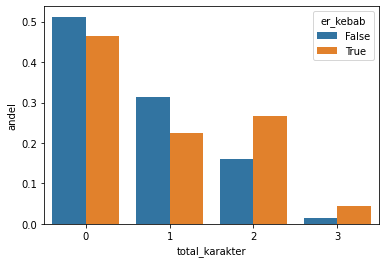

In [222]:
sns.barplot(
    data = counts, 
    x = "total_karakter",
    y = "andel",
    hue = "er_kebab"
)

<AxesSubplot:xlabel='er_kebab', ylabel='total_karakter'>

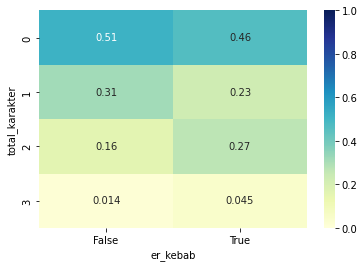

In [223]:
sns.heatmap(
    data = counts.pivot("total_karakter", "er_kebab", "andel"), 
    annot = True, 
    cmap = "YlGnBu", 
    vmin = 0, 
    vmax = 1
)

## Poststed

In [224]:
def fct_lump(col, min_freq = 0.01, new_name = 'other'):
    """
    This function creates a group for strings that appear less than a 
    given frequency, defined as a share of all groups (factors).

    Inspired by forcats::fct_lump() in R. 

    Args:
        col: Pandas series, column in DataFrame
        min_freq: Minimum frequency to accept as decimal before setting new_name
        new_name: String name for the new group

    Returns:
        pd.Series with lumped factors (if below threshold)
    """
    series = pd.value_counts(col)
    mask = (series/series.sum()).lt(min_freq)
    return pd.Series(np.where(col.isin(series[mask].index), new_name, col))


df_training = df_training.assign(poststed_lmp = fct_lump(df_training["poststed"], min_freq = 0.02))

<AxesSubplot:xlabel='total_karakter', ylabel='andel'>

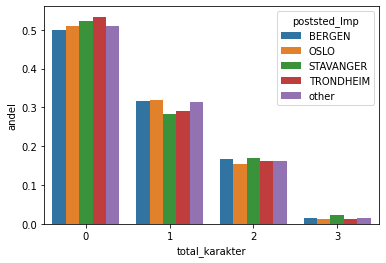

In [225]:
counts = (
    df_training
    .groupby("poststed_lmp")["total_karakter"]
    .value_counts(normalize = True)
    .rename("andel")
    .reset_index()
)

sns.barplot(
    data = counts, 
    x = "total_karakter",
    y = "andel",
    hue = "poststed_lmp"
)

<AxesSubplot:xlabel='poststed_lmp', ylabel='total_karakter'>

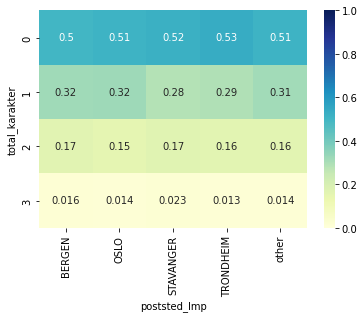

In [226]:
sns.heatmap(
    data = counts.pivot("total_karakter", "poststed_lmp", "andel"), 
    annot = True, 
    cmap = "YlGnBu", 
    vmin = 0, 
    vmax = 1
)

# Lag modell

In [227]:
#Definerer x og y variabler
x_vars = ['er_kebab', 'tilsynsbesoektype', 'poststed']
X = df_training[x_vars]
y = df_training['total_karakter']

# Definer training og testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

print(f'Training Set: {X_train.shape[0]:,d} rows\nTest Set: {X_test.shape[0]:,d} rows')

Training Set: 24,797 rows
Test Set: 10,628 rows


In [228]:
# Steps for numeriske variabler
numeric_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'mean'))
    ]
)

# Steps for kategoriske variabler
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

# Finn numeriske og kategoriske kolonner
numeric_features = X_train.select_dtypes(include = ['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include = ['object']).columns

preprocessor = ColumnTransformer(
    transformers = [
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ]
)

# Kombiner Pipeline med modell (her: lineær regresjon)
lm = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('modell', LinearRegression())
    ]
)

In [229]:
# Tren Pipelinen
lm.fit(X_train, y_train)

# Bruk pipeline på nye data
pred = lm.predict(X_test)

Siden vi har behandlet input som numerisk må vi konvertere for å få "harde" prediksjoner. Vi velger her å bruke en enkel "round": 


In [230]:
# Begrenser prediksjonen til [0, 3] 
pred = np.clip(pred, 0, 3)

softpred = pred
hardpred = pred.round()

# Validering av modell
Som valideringsmetric scores dere på macro-averaged MAE, eller MMAE, som er et måltall som egner seg for ordinale utfall når utfallet er ubalansert, les mer [her](https://stats.stackexchange.com/questions/338904/measures-of-ordinal-classification-error-for-ordinal-regression).

Dette er gjennomsnittlig avvik per risikonivå. Det vil si at dersom du predikerer kun 0 eller 1 på alle (de vanligste verdiene), så vil du få en ganske dårlig score - fordi du vil straffes hardt for alle du bommer på som skulle hatt 2 eller 3, selv om det er veldig få av disse. 

Dere velger selv om dere vil sende inn "harde prediksjoner" (eks: 0, 1, 2, 3) eller "myke" prediksjoner (eks: 0.13, 0.89, 2.42, 2.99). 

Merk at jo lavere MMAE, jo bedre er modellen. 

In [231]:
def mmae(y_true, y_pred):
    """
    Funksjonen beregner Macro Averaged Mean Absolute Error.  
    Dvs at den beregner MAE per class i y_true, og tar snittet av disse. 

    Params:
        y_true: Vektor med sanne verdier
        y_pred: Vektor med predikerte verdier
    """
    df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred})
    maes = df.groupby("y_true").apply(lambda d: mean_absolute_error(d["y_true"], d["y_pred"]))
    return maes.mean()

mmae_lm_hard = mmae(y_test, y_pred = hardpred)
mmae_lm_soft = mmae(y_test, y_pred = softpred)

print(f"MMAE (hard) = {mmae_lm_hard},\nMMAE (soft) = {mmae_lm_soft}")

MMAE (hard) = 1.0132907154297661,
MMAE (soft) = 1.0494173486224183


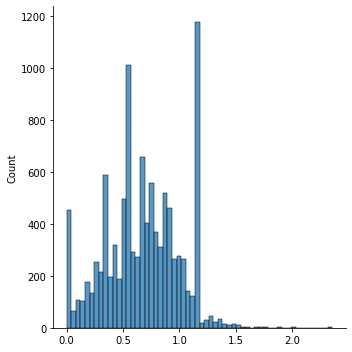

In [232]:
sns.displot(data = softpred)

<AxesSubplot:ylabel='count'>

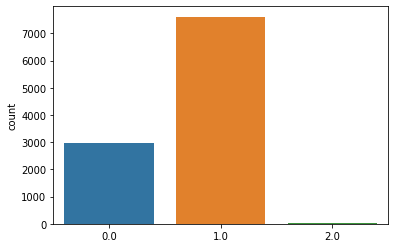

In [233]:
sns.countplot(x = hardpred)

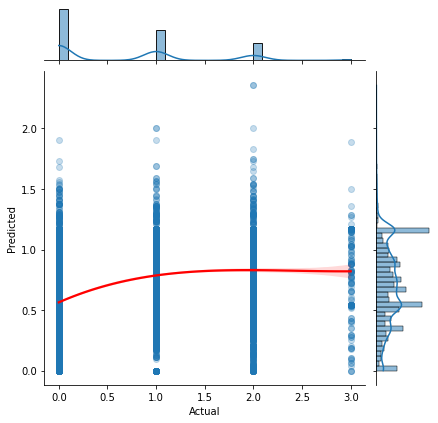

In [234]:
import matplotlib.pyplot as plt

p = sns.jointplot(
    y = softpred, 
    x = y_test, 
    kind = "reg", 
    joint_kws = {
        "scatter_kws":{"alpha": 0.25}, 
        "line_kws": {"color":"red"},
        "order":3
    }
)

p.ax_joint.set_xlabel("Actual")
p.ax_joint.set_ylabel("Predicted")
plt.show()

# Appendix
## Tuning
Ønsker du å tune modellen, kan følgende kodesnutt hjelpe. Vi tuner her Lasso-modellen sitt alpha-parameter

Merk at vi anbefaler ikke å bruke altfor mye tid på tuning da det ofte er lite å hente og tar mye tid (spesielt med dårlig PC), men dersom man er fornøyd med modellen ellers kan tuning være det "lille ekstra" som skiller førsteplass og andreplass!


In [235]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn import linear_model

Tuning kan også benyttes med pipeline. Da må du legge til navnet på modellen i pipen som prefix til hvert parameternavn, etterfulgt av to understreker. For eksempel: i pipen underga vi modellen navnet modell, da må parameternavnene i grid={...} bli modell__alpha

In [241]:
# Kombiner Pipeline med modell (her: Lasso. husk å inkludere modellnavnet i Grid under)
ls = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('modell', linear_model.Lasso())
    ]
)

In [242]:
grid = {
    'modell__alpha': [0.1, 0.2]
}

kfold = KFold(n_splits = 5)

In [243]:
grid = GridSearchCV(
  ls,
  param_grid = grid,
  cv = kfold,
  scoring = 'neg_mean_absolute_error', # OBS: Optimalt sett bruk MMAE her
  verbose = 1,
  n_jobs = -1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['tilsynsbesoektype'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                       

In [244]:
print(grid.best_params_)

{'modell__alpha': 0.1}


## Finne vanligste ord eller ngrams i orgnavn
Under finner vi de vanligste ordene som opptrer i datasettet. Kanskje noen av de kan skille seg ut?

In [189]:
pd.Series(' '.join(df_training['navn']).split()).value_counts()[:15]

AS            3230
RESTAURANT    2537
&             2436
OG            2345
CAFE          1649
KAFE          1566
-             1561
PIZZA         1396
HOTEL         1094
BAR            947
HOTELL         881
SUSHI          872
BAKERI         713
HOUSE          684
AVD.           609
dtype: int64